https://github.com/heartcored98/Standalone-DeepLearning/blob/master/Lec4/Lab6_result_report.ipynb

In [ ]:
!mkdir results
!ls results

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import argparse
import numpy as np
import time
from copy import deepcopy # Add Deepcopy for args

In [ ]:
# Data Preparation
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainset, valset = torch.utils.data.random_split(trainset, [40000, 10000])
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

partition = {'train': trainset, 'val':valset, 'test':testset}

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
# Model Architecture
class MLP(nn.Module):
    def __init__(self, in_dim, out_dim, hid_dim, n_layer, act, dropout, use_bn, use_xavier):
        super(MLP, self).__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.hid_dim = hid_dim
        self.n_layer = n_layer
        self.act = act
        self.dropout = dropout
        self.use_bn = use_bn
        self.use_xavier = use_xavier
        
        # ====== Create Linear Layers ====== #
        self.fc1 = nn.Linear(self.in_dim, self.hid_dim)
        
        self.linears = nn.ModuleList()
        self.bns = nn.ModuleList()
        for i in range(self.n_layer-1):
            self.linears.append(nn.Linear(self.hid_dim, self.hid_dim))
            if self.use_bn:
                self.bns.append(nn.BatchNorm1d(self.hid_dim))
                
        self.fc2 = nn.Linear(self.hid_dim, self.out_dim)
        
        # ====== Create Activation Function ====== #
        if self.act == 'relu':
            self.act = nn.ReLU()
        elif self.act == 'tanh':
            self.act == nn.Tanh()
        elif self.act == 'sigmoid':
            self.act = nn.Sigmoid()
        else:
            raise ValueError('no valid activation function selected!')
        
        # ====== Create Regularization Layer ======= #
        self.dropout = nn.Dropout(self.dropout)
        if self.use_xavier:
            self.xavier_init()
          
    def forward(self, x):
        x = self.act(self.fc1(x))
        for i in range(len(self.linears)):
            x = self.act(self.linears[i](x))
            x = self.bns[i](x)
            x = self.dropout(x)
        x = self.fc2(x)
        return x
    
    def xavier_init(self):
        for linear in self.linears:
            nn.init.xavier_normal_(linear.weight)
            linear.bias.data.fill_(0.01)
            
net = MLP(3072, 10, 100, 4, 'relu', 0.1, True, True) # Testing Model Construction

In [ ]:
# Train, Validation, Test and Experiment
def train(net, partition, optimizer, criterion, args):
    trainloader = torch.utils.data.DataLoader(partition['train'], 
                                              batch_size=args.train_batch_size, 
                                              shuffle=True, num_workers=2)
    net.train()
    optimizer.zero_grad()

    correct = 0
    total = 0
    train_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        inputs = inputs.view(-1, 3072)
        inputs = inputs.cuda()
        labels = labels.cuda()
        outputs = net(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = train_loss / len(trainloader)
    train_acc = 100 * correct / total
    return net, train_loss, train_acc

In [ ]:
def validate(net, partition, criterion, args):
    valloader = torch.utils.data.DataLoader(partition['val'], 
                                            batch_size=args.test_batch_size, 
                                            shuffle=False, num_workers=2)
    net.eval()

    correct = 0
    total = 0
    val_loss = 0 
    with torch.no_grad():
        for data in valloader:
            images, labels = data
            images = images.view(-1, 3072)
            images = images.cuda()
            labels = labels.cuda()
            outputs = net(images)

            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        val_loss = val_loss / len(valloader)
        val_acc = 100 * correct / total
    return val_loss, val_acc

In [ ]:
def test(net, partition, args):
    testloader = torch.utils.data.DataLoader(partition['test'], 
                                             batch_size=args.test_batch_size, 
                                             shuffle=False, num_workers=2)
    net.eval()
    
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images = images.view(-1, 3072)
            images = images.cuda()
            labels = labels.cuda()

            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        test_acc = 100 * correct / total
    return test_acc

In [ ]:
def experiment(partition, args):
  
    net = MLP(args.in_dim, args.out_dim, args.hid_dim, args.n_layer, args.act, args.dropout, args.use_bn, args.use_xavier)
    net.cuda()

    criterion = nn.CrossEntropyLoss()
    if args.optim == 'SGD':
        optimizer = optim.RMSprop(net.parameters(), lr=args.lr, weight_decay=args.l2)
    elif args.optim == 'RMSprop':
        optimizer = optim.RMSprop(net.parameters(), lr=args.lr, weight_decay=args.l2)
    elif args.optim == 'Adam':
        optimizer = optim.Adam(net.parameters(), lr=args.lr, weight_decay=args.l2)
    else:
        raise ValueError('In-valid optimizer choice')
    
    # ===== List for epoch-wise data ====== #       # 매 epoch 마다의 값을 저장하기 위한 리스트
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
    # ===================================== #
        
    for epoch in range(args.epoch):  # loop over the dataset multiple times
        ts = time.time()
        net, train_loss, train_acc = train(net, partition, optimizer, criterion, args)
        val_loss, val_acc = validate(net, partition, criterion, args)
        te = time.time()
        
        # ====== Add Epoch Data ====== #
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        # ============================ #
        
        print('Epoch {}, Acc(train/val): {:2.2f}/{:2.2f}, Loss(train/val) {:2.2f}/{:2.2f}. Took {:2.2f} sec'.format(epoch, train_acc, val_acc, train_loss, val_loss, te-ts))
        
    test_acc = test(net, partition, args)    
    
    # ======= Add Result to Dictionary ======= #
    result = {}                                     # Dictionary 'result'에 결과값 추가
    result['train_losses'] = train_losses       
    result['val_losses'] = val_losses
    result['train_accs'] = train_accs
    result['val_accs'] = val_accs
    result['train_acc'] = train_acc
    result['val_acc'] = val_acc
    result['test_acc'] = test_acc
    return vars(args), result                       # vars(): args를 vars로 Dictionary로 만듦
    # ===================================== #

In [ ]:
# Manage Experiment Result
import hashlib
import json
from os import listdir
from os.path import isfile, join
import pandas as pd

def save_exp_result(setting, result):
    exp_name = setting['exp_name']
    del setting['epoch']                # setting Dictionary안의 epoch값을 지움. 이후에 epoch를 더 올리고 싶은데 이 부분을 안 지우면 파일이 따로 생김.
    del setting['test_batch_size']      # batch size는 실험 결과에 영향을 안 주므로 Hash를 만들때 고려가 안되도록 del을 해주는 것

    hash_key = hashlib.sha1(str(setting).encode()).hexdigest()[:6]
    filename = './results/{}-{}.json'.format(exp_name, hash_key)
    result.update(setting)              # update(): result는 실험결과를 담은 Dictionary인데 setting 내용도 함꼐 저장하기 위함, update: dictionary끼리(key, value 값 둘다) 합치는 함수
    with open(filename, 'w') as f:
        json.dump(result, f)

    
def load_exp_result(exp_name):
    dir_path = './results'
    filenames = [f for f in listdir(dir_path) if isfile(join(dir_path, f)) if '.json' in f]
    list_result = []
    for filename in filenames:
        if exp_name in filename:
            with open(join(dir_path, filename), 'r') as infile:
                results = json.load(infile)
                list_result.append(results)
    df = pd.DataFrame(list_result) # .drop(columns=[])
    return df
    

In [ ]:
# Experiment
# ====== Random Seed Initialization ====== #
seed = 123
np.random.seed(seed)
torch.manual_seed(seed)

parser = argparse.ArgumentParser()
args = parser.parse_args("")
args.exp_name = "exp1_n_layer_hid_dim"      # 여기서는 어떤 것을 바꾸면서 실험했는지를 명시했음

# ====== Model Capacity ====== #
args.in_dim = 3072
args.out_dim = 10
args.hid_dim = 100
args.act = 'relu'

# ====== Regularization ======= #
args.dropout = 0.2
args.use_bn = True
args.l2 = 0.00001
args.use_xavier = True

# ====== Optimizer & Training ====== #
args.optim = 'RMSprop' #'RMSprop' #SGD, RMSprop, ADAM...
args.lr = 0.0015
args.epoch = 10

args.train_batch_size = 256
args.test_batch_size = 1024

# ====== Experiment Variable ====== #
name_var1 = 'n_layer'       # str
name_var2 = 'hid_dim'
list_var1 = [1, 2, 3]       # n_layer
list_var2 = [500, 300]      # hid_dim


for var1 in list_var1:          # Experiment가 하나 끝날때마다 result가 저장됨
    for var2 in list_var2:
        setattr(args, name_var1, var1)      # setattr() == 'args.name_var1 = var1' --> string인 name_var1 항목값을 var1 항목값으로 다시 셋팅하는 문법
        setattr(args, name_var2, var2)      # 함수명을 안 바꾸고 실수고 Train하여 시간 낭비하는 것을 방지하기 위함
        print(args)
                
        setting, result = experiment(partition, deepcopy(args))
        save_exp_result(setting, result)                            # 설정한 setting 값에 따라 result가 저장됨


Namespace(act='relu', dropout=0.2, epoch=10, exp_name='exp1_n_layer_hid_dim', hid_dim=500, in_dim=3072, l2=1e-05, lr=0.0015, n_layer=1, optim='RMSprop', out_dim=10, test_batch_size=1024, train_batch_size=256, use_bn=True, use_xavier=True)
Epoch 0, Acc(train/val): 23.70/22.52, Loss(train/val) 23.11/26.46. Took 11.84 sec
Epoch 1, Acc(train/val): 26.36/26.12, Loss(train/val) 23.29/25.45. Took 12.02 sec
Epoch 2, Acc(train/val): 26.12/27.30, Loss(train/val) 18.40/23.43. Took 11.82 sec
Epoch 3, Acc(train/val): 27.20/25.81, Loss(train/val) 16.98/20.25. Took 11.95 sec
Epoch 4, Acc(train/val): 27.08/22.67, Loss(train/val) 16.17/26.11. Took 11.85 sec
Epoch 5, Acc(train/val): 26.84/27.27, Loss(train/val) 18.73/22.85. Took 11.98 sec
Epoch 6, Acc(train/val): 27.38/26.59, Loss(train/val) 19.23/24.02. Took 11.93 sec
Epoch 7, Acc(train/val): 28.09/27.42, Loss(train/val) 19.42/22.84. Took 11.92 sec
Epoch 8, Acc(train/val): 28.76/26.04, Loss(train/val) 16.19/22.45. Took 11.92 sec
Epoch 9, Acc(train/val)

In [ ]:
!ls results
!cat results/exp1_n_layer_hid_dim-41b634.json       # 파일안에는 각 10개의 loss들의 결과값과 hyperparameter들의 값들을 들어 있음을 확인할 수 있음

exp1_n_layer_hid_dim-41b634.json  exp1_n_layer_hid_dim-bfc899.json
exp1_n_layer_hid_dim-61a2d0.json  exp1_n_layer_hid_dim-cab8c1.json
exp1_n_layer_hid_dim-7b70fe.json  exp1_n_layer_hid_dim-dece45.json
{"train_losses": [2.195293570020396, 1.8849662944769403, 1.7684639699899467, 1.702119100625348, 1.6568804341516676, 1.5971092646289025, 1.523966144604288, 1.4696454121049043, 1.4142106088103763, 1.3780287010654522], "val_losses": [1.9064837336540221, 1.7632539868354797, 1.7363317489624024, 1.6865941405296325, 1.6501375555992126, 1.572830581665039, 1.5575632095336913, 1.5305028796195983, 1.5137670874595641, 1.4787207126617432], "train_accs": [25.365, 32.2375, 35.635, 38.3625, 39.87, 42.23, 45.2025, 47.3325, 49.2875, 50.925], "val_accs": [32.75, 36.04, 37.88, 38.34, 39.87, 44.06, 44.52, 45.47, 45.12, 47.44], "train_acc": 50.925, "val_acc": 47.44, "test_acc": 48.31, "exp_name": "exp1_n_layer_hid_dim", "in_dim": 3072, "out_dim": 10, "hid_dim": 300, "act": "relu", "dropout": 0.2, "use_bn": tru

0.11.1


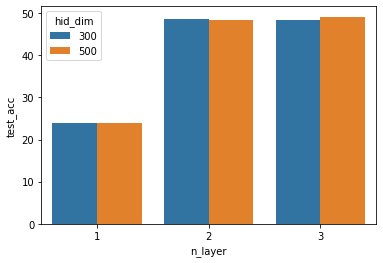

In [ ]:
# Dictionary에 저장된 데이터중 필요한 데이터만 뽑아서 그래프로 만들어 흐름에 따른 결과를 시각화하기
# results = load_exp_result('exp1')
# print(results)
result = load_exp_result('exp1')            
# load_exp_result('exp1')                   # 가독성이 더 좋게 출력이 됨
# print(type(load_exp_result('exp1')))      # <class 'pandas.core.frame.DataFrame'>, Pandas: Python계의 Excel


# a = [{'age':5, 'gender':'f', 'score':10, 't':1}, {'age':6, 'gender':'m', 'score':40, 't':2}, 
#      {'age':10, 'gender':'m', 'score':50, 't':1}, {'age':15, 'gender':'f', 'score':90, 't':2}, 
#      {'age':19, 'gender':'f', 'score':75, 't':2}, {'age': 27, 'gender':'f', 'score':100, 't':1}]
# df = pd.DataFrame(a)      # 데이터를 표로 시각화


# layer수와 hid_dim에 따른 acc 확인
import seaborn as sns       # visual lib
print(sns.__version__)
sns.barplot(x='n_layer', y='test_acc', hue='hid_dim', data=result)      

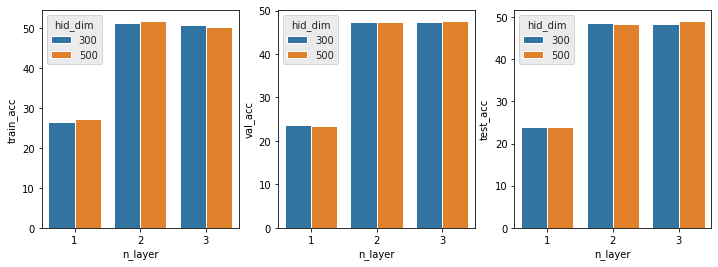

In [ ]:
import seaborn as sns 
import matplotlib.pyplot as plt

df = load_exp_result('exp1')

fig, ax = plt.subplots(1, 3)
fig.set_size_inches(12, 4)
sns.set_style("darkgrid", {"axes.facecolor": ".9"})     # 그리드 테마

sns.barplot(x='n_layer', y='train_acc', hue='hid_dim', data=df, ax=ax[0])
sns.barplot(x='n_layer', y='val_acc', hue='hid_dim', data=df, ax=ax[1])
sns.barplot(x='n_layer', y='test_acc', hue='hid_dim', data=df, ax=ax[2])


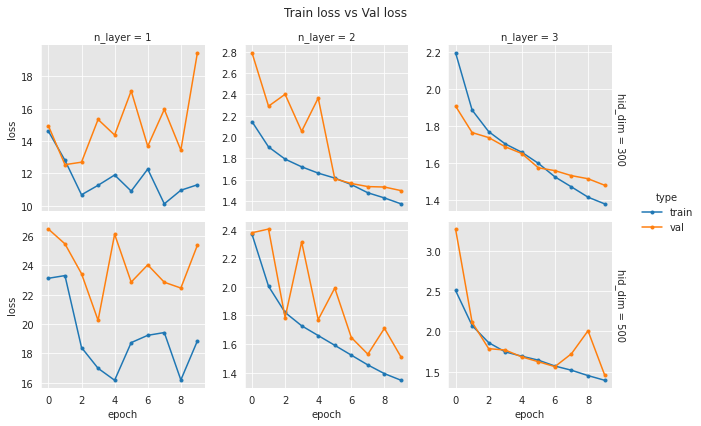

In [ ]:
# 시각화 하는건데 디게 복잡.... 5차원이라서, 설명포기... 하루정도 열심히 분석하면 깨닫는다고함? 

var1 = 'n_layer'
var2 = 'hid_dim'

df = load_exp_result('exp1')
list_v1 = df[var1].unique()     # unique(): var1(n_layer)만 가져오겠다는 것
list_v2 = df[var2].unique()
# print(list_v1, list_v2)                   # [1, 2, 3], [300, 500]
list_data = []

for value1 in list_v1:
    for value2 in list_v2:
        row = df.loc[df[var1]==value1]      # 
        row = row.loc[df[var2]==value2]
        # print(value1, valuerow)
        
        train_losses = list(row.train_losses)[0]
        val_losses = list(row.val_losses)[0]
        
        for epoch, train_loss in enumerate(train_losses):
            list_data.append({'type':'train', 'loss':train_loss, 'epoch':epoch, var1:value1, var2:value2})
        for epoch, val_loss in enumerate(val_losses):
            list_data.append({'type':'val', 'loss':val_loss, 'epoch':epoch, var1:value1, var2:value2})
        
df = pd.DataFrame(list_data)
g = sns.FacetGrid(df, row=var2, col=var1, hue='type', margin_titles=True, sharey=False)     # 어떤식으로 그래프를 그릴것인지 틀을 정의
g = g.map(plt.plot, 'epoch', 'loss', marker='.')        # g.map(): plt.plot인 각각의 서브 plot에서 실행 시킬것이다
g.add_legend()
g.fig.suptitle('Train loss vs Val loss')
plt.subplots_adjust(top=0.89)

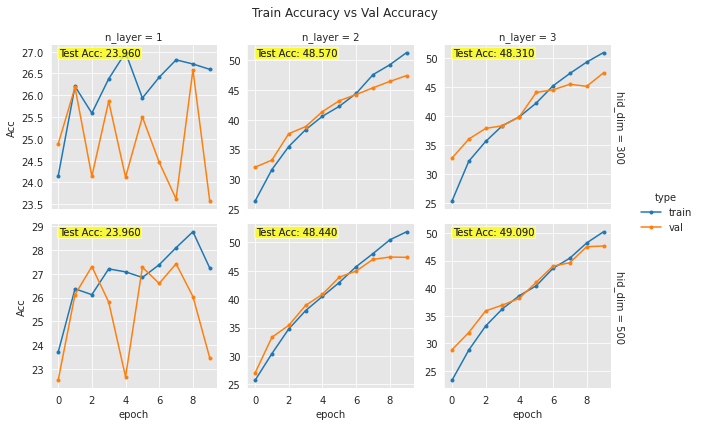

In [ ]:
'''
이렇게 그래프를 그리고(어우 그리는 것도 함들다) 어떻게 활용할지가 중요
1) 일단 Test Acc가 가장 높은 것을 확인
'''

var1 = 'n_layer'
var2 = 'hid_dim'

df = load_exp_result('exp1')
list_v1 = df[var1].unique()
list_v2 = df[var2].unique()
list_data = []

for value1 in list_v1:
    for value2 in list_v2:
        row = df.loc[df[var1]==value1]
        row = row.loc[df[var2]==value2]
        
        train_accs = list(row.train_accs)[0]
        val_accs = list(row.val_accs)[0]
        test_acc = list(row.test_acc)[0]
        
        for epoch, train_acc in enumerate(train_accs):
            list_data.append({'type':'train', 'Acc':train_acc, 'test_acc':test_acc, 'epoch':epoch, var1:value1, var2:value2})
        for epoch, val_acc in enumerate(val_accs):
            list_data.append({'type':'val', 'Acc':val_acc, 'test_acc':test_acc, 'epoch':epoch, var1:value1, var2:value2})
        
df = pd.DataFrame(list_data)
g = sns.FacetGrid(df, row=var2, col=var1, hue='type', margin_titles=True, sharey=False)
g = g.map(plt.plot, 'epoch', 'Acc', marker='.')

def show_acc(x, y, metric, **kwargs):
    plt.scatter(x, y, alpha=0.3, s=1)
    metric = "Test Acc: {:1.3f}".format(list(metric.values)[0])
    plt.text(0.05, 0.95, metric,  horizontalalignment='left', verticalalignment='center', transform=plt.gca().transAxes, bbox=dict(facecolor='yellow', alpha=0.5, boxstyle="round,pad=0.1"))
g = g.map(show_acc, 'epoch', 'Acc', 'test_acc')

g.add_legend()
g.fig.suptitle('Train Accuracy vs Val Accuracy')

plt.subplots_adjust(top=0.89)

In [ ]:
# 위의 결과를 보고 Fine-tunning 하기
'''
Experiment2 --> exp1에서는 n_layer = 3, hid_dim = 300 일때 더 높은 Accuracy에 도달할 수 있으므로 
                저 두 값은 고정시키고 다른 하이퍼파라미터를 조정해본다.
바꿔볼 하이퍼 파라미터: lr(learning rate), dropout
참고) optimizer는 따로 단독으로 실험해보는 것이 조음
'''
# ====== Random Seed Initialization ====== #
seed = 123
np.random.seed(seed)
torch.manual_seed(seed)

parser = argparse.ArgumentParser()
args = parser.parse_args("")
args.exp_name = "exp2_lr_dropout"      # 여기서는 어떤 것을 바꾸면서 실험했는지를 명시했음

# ====== Model Capacity ====== #
args.n_layer = 3
args.in_dim = 3072
args.out_dim = 10
args.hid_dim = 300          # updated
args.act = 'relu'

# ====== Regularization ======= #
# args.dropout = 0.2        # updated to remove temporarly
args.use_bn = True
args.l2 = 0.00001
args.use_xavier = True

# ====== Optimizer & Training ====== #
args.optim = 'RMSprop' #'RMSprop' #SGD, RMSprop, ADAM...
# args.lr = 0.0015          # updated to remove temporarly
args.use_bn = True
args.epoch = 10

args.train_batch_size = 256
args.test_batch_size = 1024

# ====== Experiment Variable ====== #
name_var1 = 'lr'            # updated, 여기서 변수명은 args에서 지정해주었던 변수명과 같아야함
name_var2 = 'dropout'       # updated
list_var1 = [0.0001, 0.005, 0.001]       # n_layer
list_var2 = [0.3, 0.5, 0.7]      # hid_dim


for var1 in list_var1:          # Experiment가 하나 끝날때마다 result가 저장됨
    for var2 in list_var2:
        setattr(args, name_var1, var1)      # setattr == args.name_var1 = var1 --> name_var1 항목값을 var1 항목값으로 다시 셋팅하는 문법
        setattr(args, name_var2, var2)      # 함수명을 안 바꾸고 실수고 Train하여 시간 낭비하는 것을 방지하기 위함
        print(args)
                
        setting, result = experiment(partition, deepcopy(args))
        save_exp_result(setting, result)


Namespace(act='relu', dropout=0.3, epoch=10, exp_name='exp2_lr_dropout', hid_dim=300, in_dim=3072, l2=1e-05, lr=0.0001, n_layer=3, optim='RMSprop', out_dim=10, test_batch_size=1024, train_batch_size=256, use_bn=True, use_xavier=True)
Epoch 0, Acc(train/val): 34.02/40.15, Loss(train/val) 1.84/1.67. Took 12.57 sec
Epoch 1, Acc(train/val): 40.13/43.01, Loss(train/val) 1.67/1.58. Took 12.68 sec
Epoch 2, Acc(train/val): 43.74/45.73, Loss(train/val) 1.58/1.52. Took 12.49 sec
Epoch 3, Acc(train/val): 46.41/46.90, Loss(train/val) 1.49/1.49. Took 12.54 sec
Epoch 4, Acc(train/val): 49.01/47.46, Loss(train/val) 1.43/1.46. Took 12.50 sec
Epoch 5, Acc(train/val): 51.02/49.29, Loss(train/val) 1.37/1.43. Took 12.62 sec
Epoch 6, Acc(train/val): 52.75/49.87, Loss(train/val) 1.32/1.41. Took 12.66 sec
Epoch 7, Acc(train/val): 54.65/50.46, Loss(train/val) 1.27/1.40. Took 12.58 sec
Epoch 8, Acc(train/val): 55.83/50.58, Loss(train/val) 1.23/1.40. Took 12.58 sec
Epoch 9, Acc(train/val): 57.28/50.91, Loss(tra

In [ ]:
!ls -al ./results

total 68
drwxr-xr-x 2 root root 4096 Jan 13 12:03 .
drwxr-xr-x 1 root root 4096 Jan 13 11:12 ..
-rw-r--r-- 1 root root  907 Jan 13 11:25 exp1_n_layer_hid_dim-41b634.json
-rw-r--r-- 1 root root  912 Jan 13 11:17 exp1_n_layer_hid_dim-61a2d0.json
-rw-r--r-- 1 root root  907 Jan 13 11:15 exp1_n_layer_hid_dim-7b70fe.json
-rw-r--r-- 1 root root  900 Jan 13 11:23 exp1_n_layer_hid_dim-bfc899.json
-rw-r--r-- 1 root root  905 Jan 13 11:21 exp1_n_layer_hid_dim-cab8c1.json
-rw-r--r-- 1 root root  904 Jan 13 11:19 exp1_n_layer_hid_dim-dece45.json
-rw-r--r-- 1 root root  893 Jan 13 12:01 exp2_lr_dropout-2dfc53.json
-rw-r--r-- 1 root root  897 Jan 13 12:03 exp2_lr_dropout-3ba69d.json
-rw-r--r-- 1 root root  892 Jan 13 11:53 exp2_lr_dropout-3e5672.json
-rw-r--r-- 1 root root  898 Jan 13 11:46 exp2_lr_dropout-4ff480.json
-rw-r--r-- 1 root root  901 Jan 13 11:49 exp2_lr_dropout-6359e9.json
-rw-r--r-- 1 root root  895 Jan 13 11:51 exp2_lr_dropout-7a663f.json
-rw-r--r-- 1 root root  897 Jan 13 11:55 exp2_

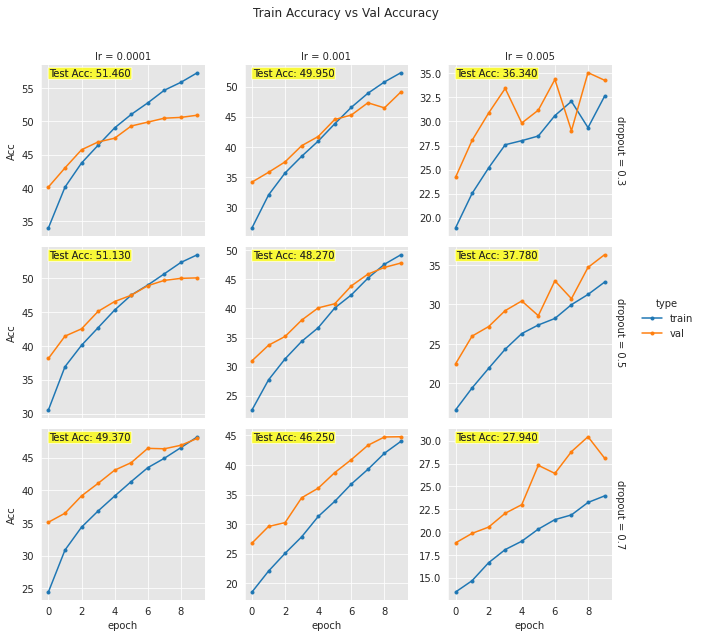

In [ ]:
var1 = 'lr'
var2 = 'dropout'

df = load_exp_result('exp2')
list_v1 = df[var1].unique()
list_v2 = df[var2].unique()
list_data = []

for value1 in list_v1:
    for value2 in list_v2:
        row = df.loc[df[var1]==value1]
        row = row.loc[df[var2]==value2]
        
        train_accs = list(row.train_accs)[0]
        val_accs = list(row.val_accs)[0]
        test_acc = list(row.test_acc)[0]
        
        for epoch, train_acc in enumerate(train_accs):
            list_data.append({'type':'train', 'Acc':train_acc, 'test_acc':test_acc, 'epoch':epoch, var1:value1, var2:value2})
        for epoch, val_acc in enumerate(val_accs):
            list_data.append({'type':'val', 'Acc':val_acc, 'test_acc':test_acc, 'epoch':epoch, var1:value1, var2:value2})
        
df = pd.DataFrame(list_data)
g = sns.FacetGrid(df, row=var2, col=var1, hue='type', margin_titles=True, sharey=False)
g = g.map(plt.plot, 'epoch', 'Acc', marker='.')

def show_acc(x, y, metric, **kwargs):
    plt.scatter(x, y, alpha=0.3, s=1)
    metric = "Test Acc: {:1.3f}".format(list(metric.values)[0])
    plt.text(0.05, 0.95, metric,  horizontalalignment='left', verticalalignment='center', transform=plt.gca().transAxes, bbox=dict(facecolor='yellow', alpha=0.5, boxstyle="round,pad=0.1"))
g = g.map(show_acc, 'epoch', 'Acc', 'test_acc')

g.add_legend()
g.fig.suptitle('Train Accuracy vs Val Accuracy')

plt.subplots_adjust(top=0.89)